# Comparison between 5kg and 0kg in acceleration data

**Description:**
Two experiments with different weights were conducted to generate 135 acceleration recordings each.
The usual nine movement classes were used. Each movement class contains 15 recordings.
This file compares recordings made WITH weights to those without via different perspectives.

**Goal:**
- Find differences in the data of both experiments to determine which classes are how affected by weights (if at all).
- document found differences and highlight classes in which no differences could be extracted
- Estimate the impact of weights in the performance of ML-Models e.g. DecisionTree

**Steps:**
1. Load the experiment data into two datasets
2. For all three axes (x, y, z) do the following
    1. Plot line-chart of the current axis for all recordings
3. condense the line-charts of one axis of all recordings of a movementclass into one diagram via
    1. calculate average values
    2. append acceleration values into one diagram with 15*40000 points on the x-axis
4. create spectrogram
5. use everywhereml-kpis
6. document results
7. determine impact on KI

0. Helper-Methods

Imports

In [47]:
import numpy as np
import os, glob, json
from typing import Tuple, Iterable
from multiprocessing import Pool, Process
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import random
from sklearn.manifold import TSNE
import tensorflow as tf

In [48]:
import os
import json
import re
import numpy as np

def parse_acceleration_data(folder_path, filenameContainsWord=None):
    """
    Parses acceleration data from JSON files in a folder.

    Args:
        folder_path (str): Path to the folder containing the JSON files.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: A tuple containing the acceleration data and the labels.

    Raises:
        ValueError: If the JSON files do not contain acceleration data with the expected format
                    or if the labels cannot be extracted from the filenames.
    """
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.json') and filenameContainsWord in f]
    num_files = len(file_names)
    acceleration_data = np.empty((num_files, 40000, 3))
    labels = np.empty((num_files, 1), dtype=np.object)

    for i, file_name in enumerate(file_names):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            json_data = json.load(file)

        if 'x' not in json_data or 'y' not in json_data or 'z' not in json_data:
            raise ValueError(f'Acceleration data not found in {file_path}')

        x_values = json_data['x']
        y_values = json_data['y']
        z_values = json_data['z']

        if len(x_values) != 40000 or len(y_values) != 40000 or len(z_values) != 40000:
            raise ValueError(f'Acceleration data size mismatch in {file_path}')

        acceleration_data[i] = np.array([x_values, y_values, z_values]).T

        # Extract label from the filename using regular expressions
        match = re.search(r'_scenario_(.*?)\.json', file_name)
        if match is None:
            raise ValueError(f'Label extraction error in {file_path}')

        label = match.group(1)
        #print(label)
        labels[i] = label

    return acceleration_data, labels




In [49]:
def getIndicesOfFirstOccurranceOfLabel(searchlabel:str, y):
    labels = np.unique(y)
    if searchlabel not in labels:
        raise Exception("invalid label", "available labels: ", labels)
    indices = []
    for idx, label in enumerate(y):
        if label[0] == searchlabel:
            indices.append(idx)
    return indices

def plotRandomDatapointsOfLabel(searchLabel, X, y, type="line", axis="x"):

    axisIndex = 0
    if axis == "x":
        axisIndex = 0
    if axis == "y":
        axisIndex = 1
    if axis == "z":
        axisIndex = 2
    plt.rcParams["figure.figsize"] = (20, 3)
    #searchLabel = "Gehen"
    
    indices = getIndicesOfFirstOccurranceOfLabel(searchLabel,y)
    randomIndex = random.randint(0, len(indices)-1)
    #randomIndex = indices[3]
    print(y[indices[randomIndex]], "Anzahl Aufnahmen: ", len(indices))
    if type=="line":
        plt.plot(X[indices[randomIndex]][:,axisIndex])
        plt.ylabel("Beschleunigung in g")
        plt.xlabel("Anzahl der Datenpunkte")
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

def plotRandomDatapointsOfEachLabel(X, y, type="line", axis="x"):
    labels = np.unique(y)
    for label in labels:
        plotRandomDatapointsOfLabel(label, X, y, type, axis)

import numpy as np
from scipy import signal
def applyLowPassFilter(X):
    # set the filter parameters
    fs = 4000  # sampling frequency in Hz
    fc = 1100  # cutoff frequency in Hz
    order = 4  # filter order

    # calculate the filter coefficients
    b, a = signal.butter(order, fc / (fs / 2), 'low')

    # apply the filter to each recording of acceleration data
    filtered_accel_data = np.zeros_like(X)

    for i in range(X.shape[0]):
        filtered_accel_data[i,:,:] = signal.filtfilt(b, a, X[i,:,:], axis=0)
    print("X:", X.shape)
    return filtered_accel_data

1. Load Data into two Datasets

dataset:
1. data_with_weights
2. data_without_weights

In [50]:
data_with_weights, labels_with_weights = parse_acceleration_data("../data/WeightsVsNoWeightsData/20230712","Weights1_5kg")
data_without_weights, labels_without_weights = parse_acceleration_data("../data/WeightsVsNoWeightsData/20230712","Weightless1")

/tmp/ipykernel_12478/3122072756.py:23: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.empty((num_files, 1), dtype=np.object)


In [51]:
data_with_weights_filtered = applyLowPassFilter(data_with_weights)
data_without_weights_filtered = applyLowPassFilter(data_without_weights)

X: (135, 40000, 3)
X: (135, 40000, 3)


In [52]:
print(data_with_weights_filtered.shape)
print(data_without_weights_filtered.shape)

(135, 40000, 3)
(135, 40000, 3)


In [53]:
print(labels_with_weights.shape)
print(labels_without_weights.shape)

(135, 1)
(135, 1)


['idle'] Anzahl Aufnahmen:  15


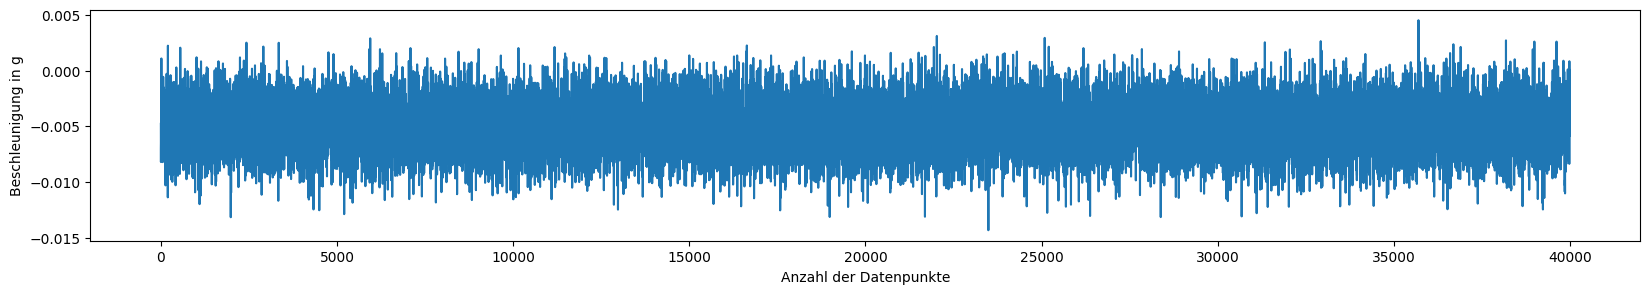

['largeloadcarriertrolley'] Anzahl Aufnahmen:  15


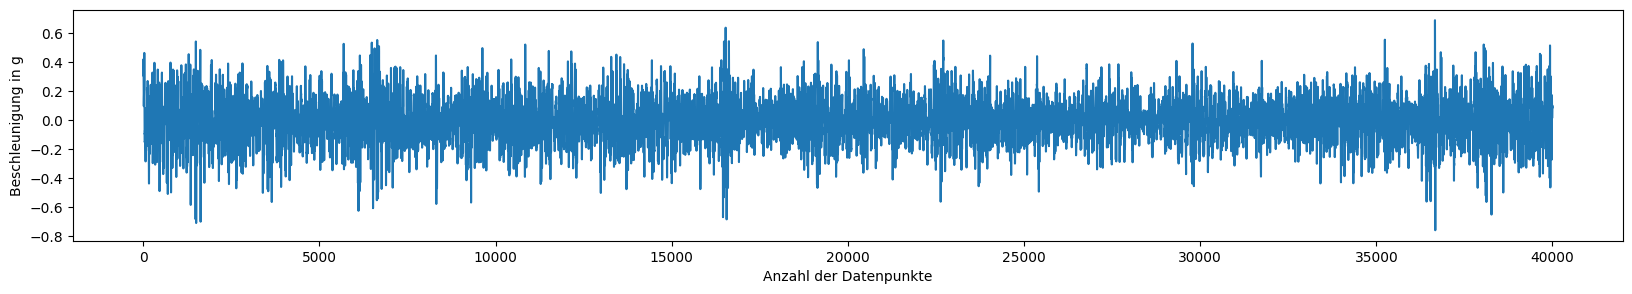

['liftingandlowering'] Anzahl Aufnahmen:  15


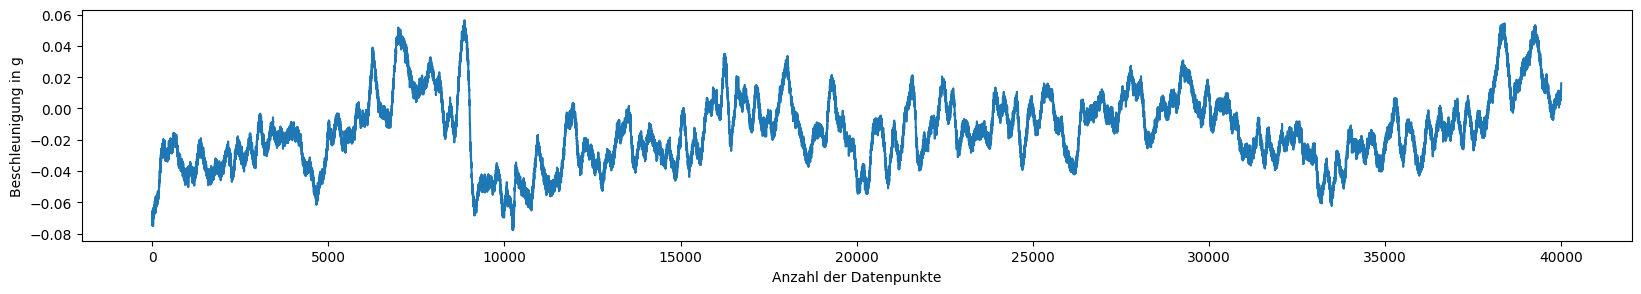

['movingtable'] Anzahl Aufnahmen:  15


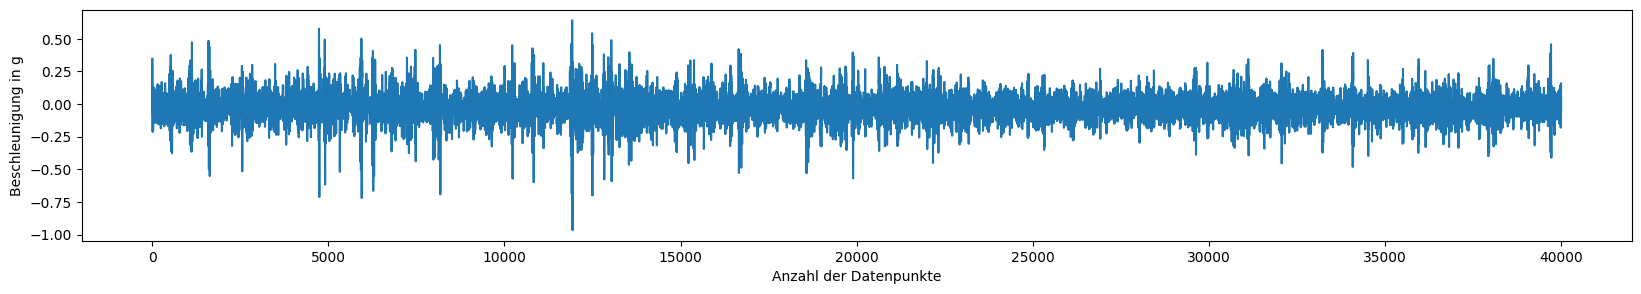

['palletjack'] Anzahl Aufnahmen:  15


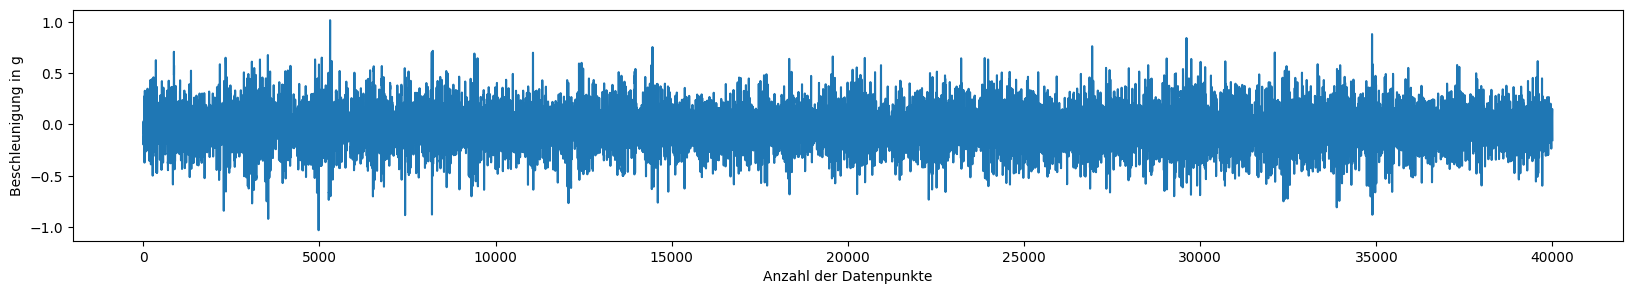

['rollerconveyor'] Anzahl Aufnahmen:  15


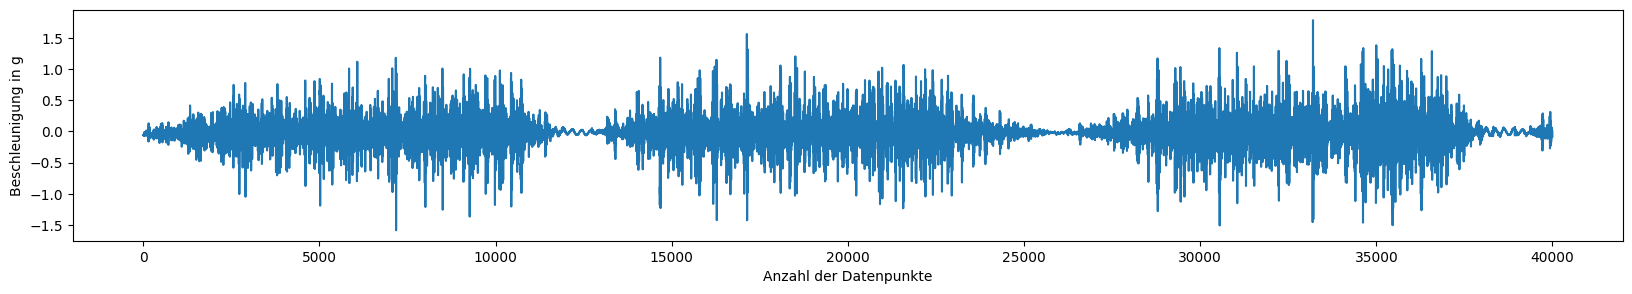

['rotatehorizontally'] Anzahl Aufnahmen:  15


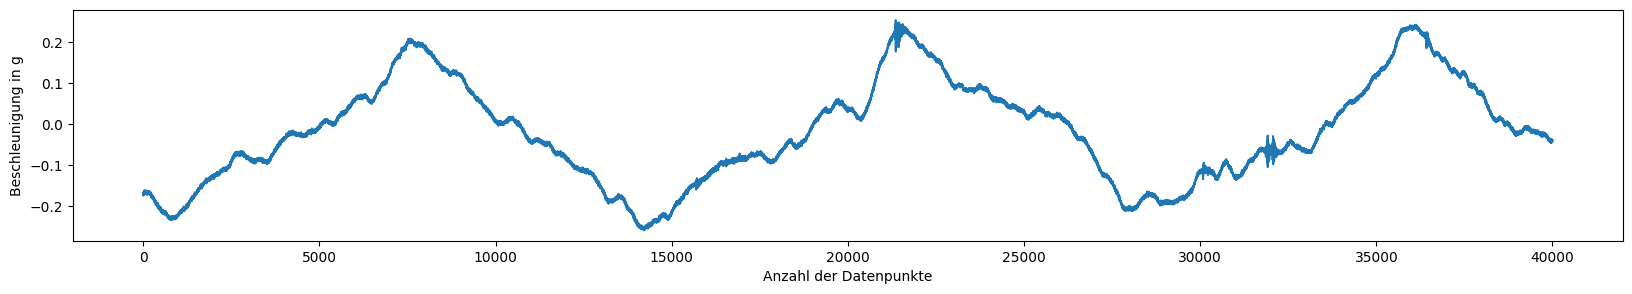

['sacktrolley'] Anzahl Aufnahmen:  15


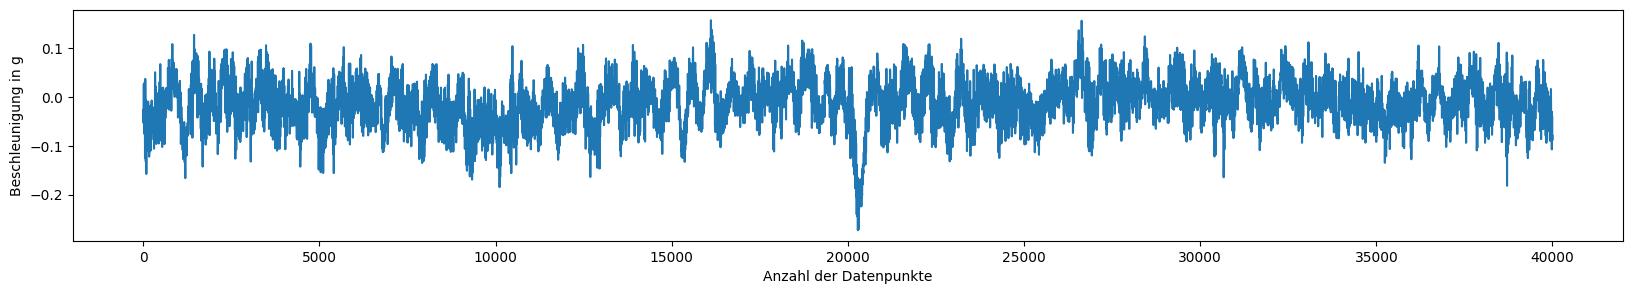

['walking'] Anzahl Aufnahmen:  15


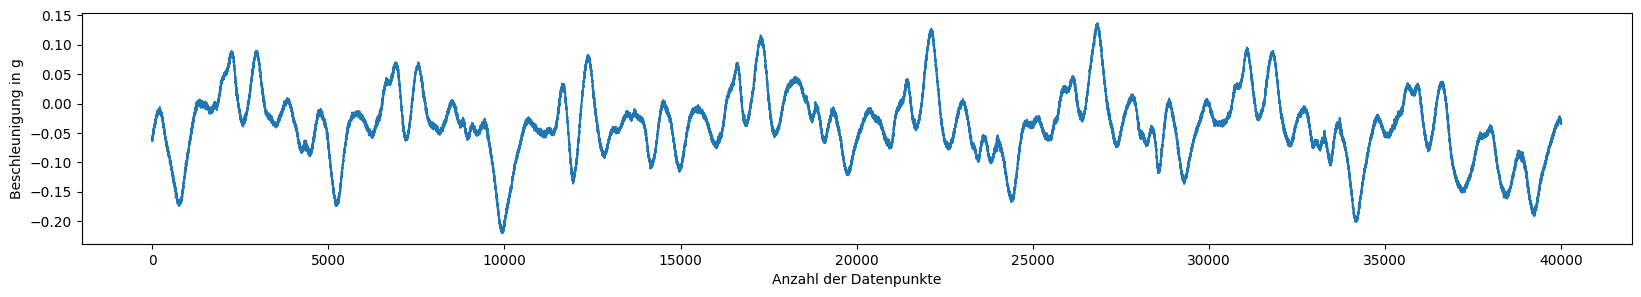

In [54]:
plotRandomDatapointsOfEachLabel(data_with_weights_filtered, labels_with_weights,type="line", axis="x")

['idle'] Anzahl Aufnahmen:  15


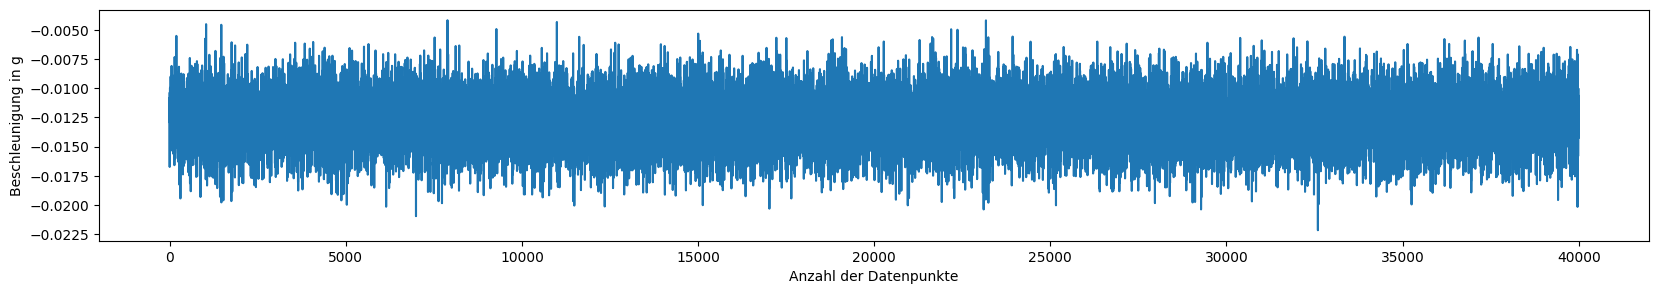

['largeloadcarriertrolley'] Anzahl Aufnahmen:  15


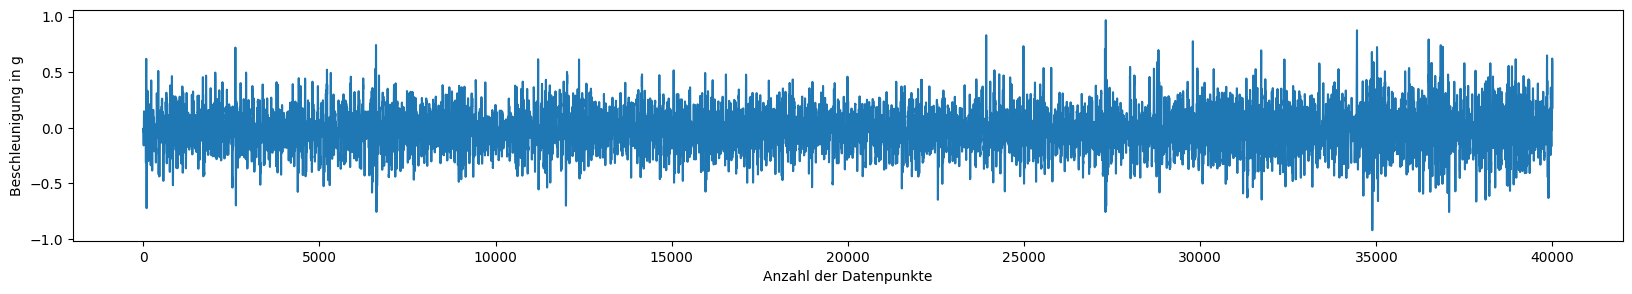

['liftingandlowering'] Anzahl Aufnahmen:  15


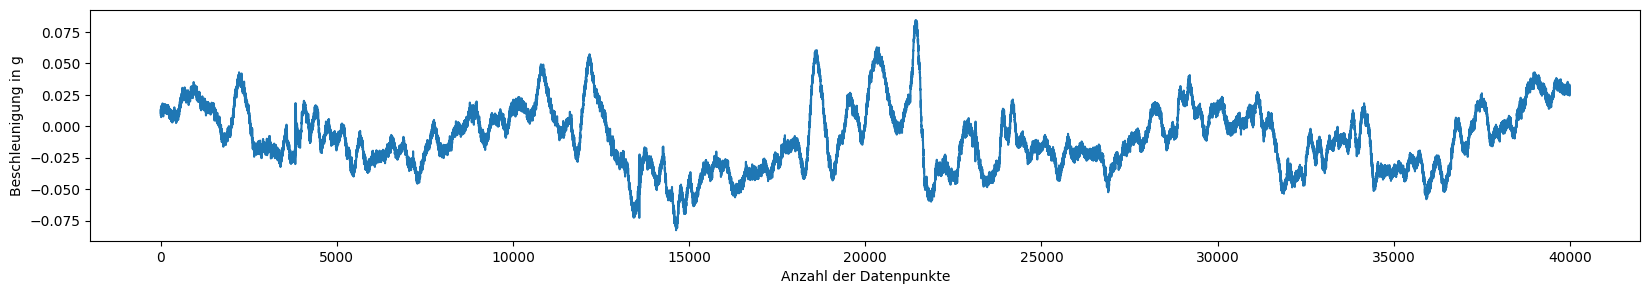

['movingtable'] Anzahl Aufnahmen:  15


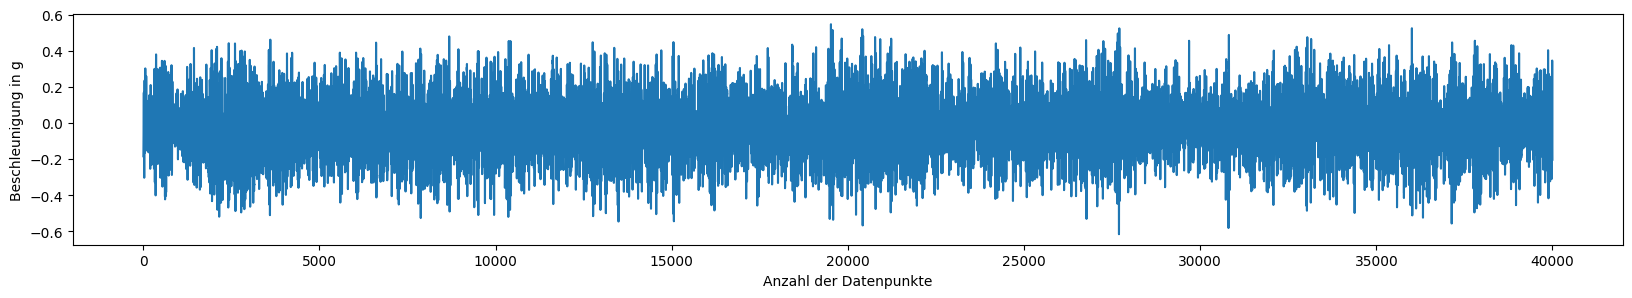

['palletjack'] Anzahl Aufnahmen:  15


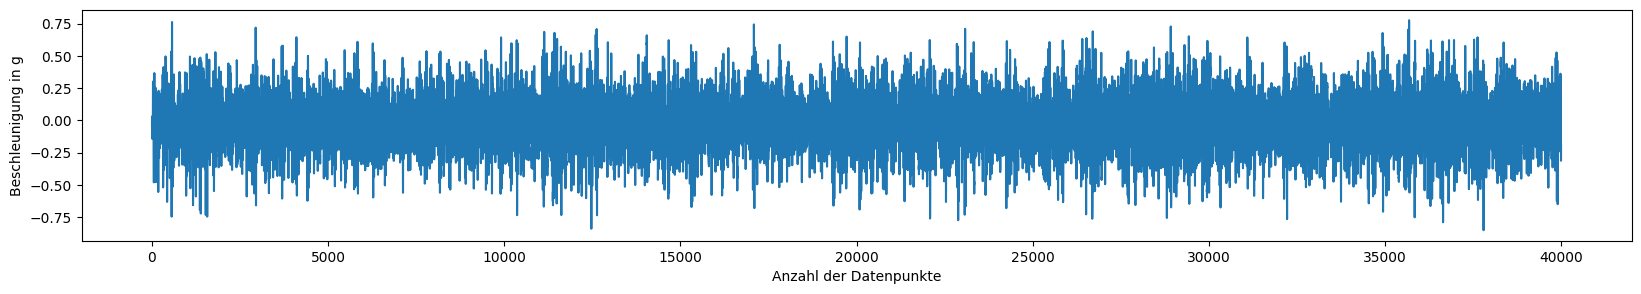

['rollerconveyor'] Anzahl Aufnahmen:  15


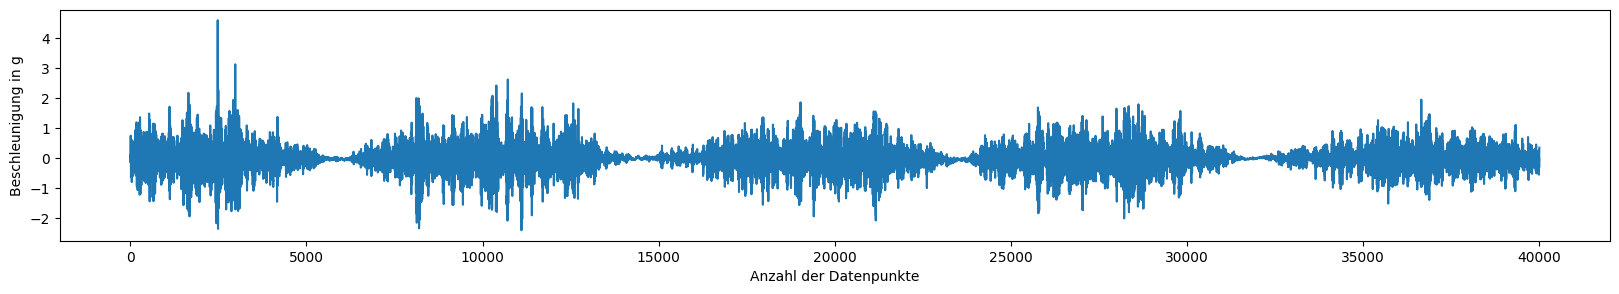

['rotatehorizontally'] Anzahl Aufnahmen:  15


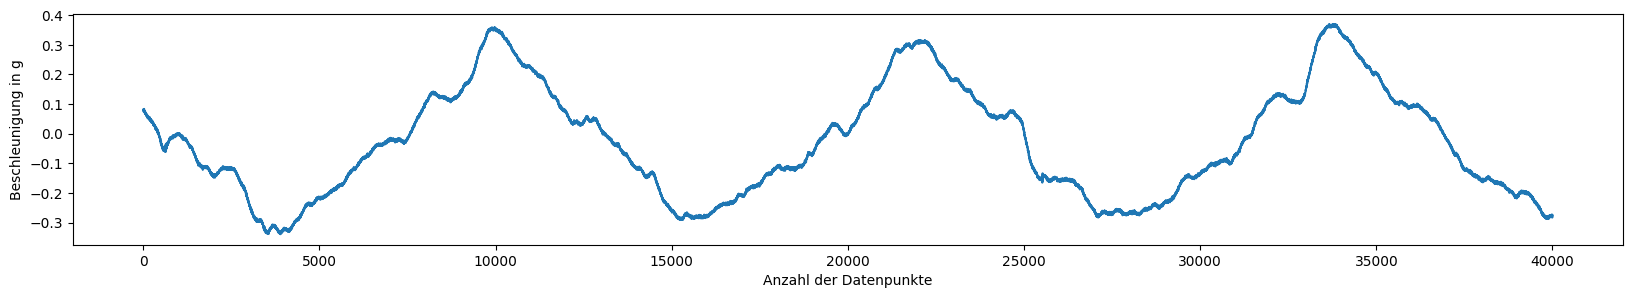

['sacktrolley'] Anzahl Aufnahmen:  15


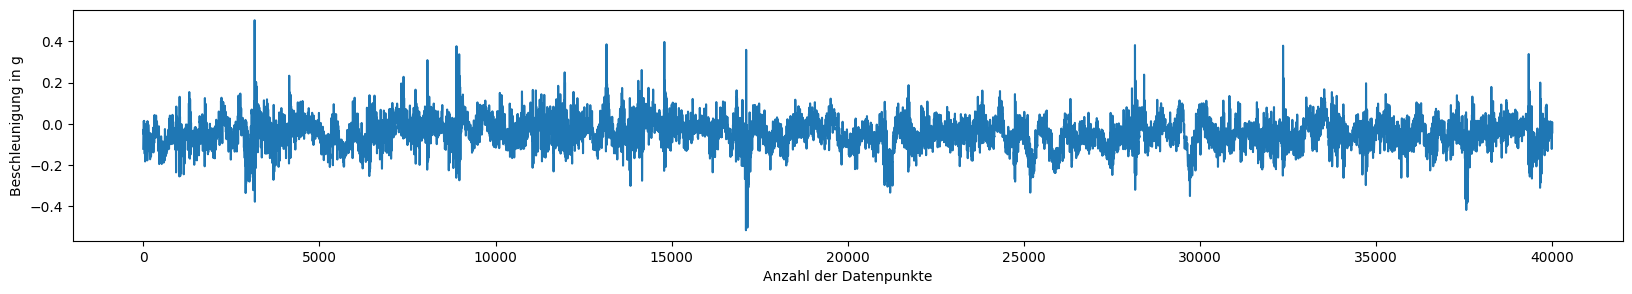

['walking'] Anzahl Aufnahmen:  15


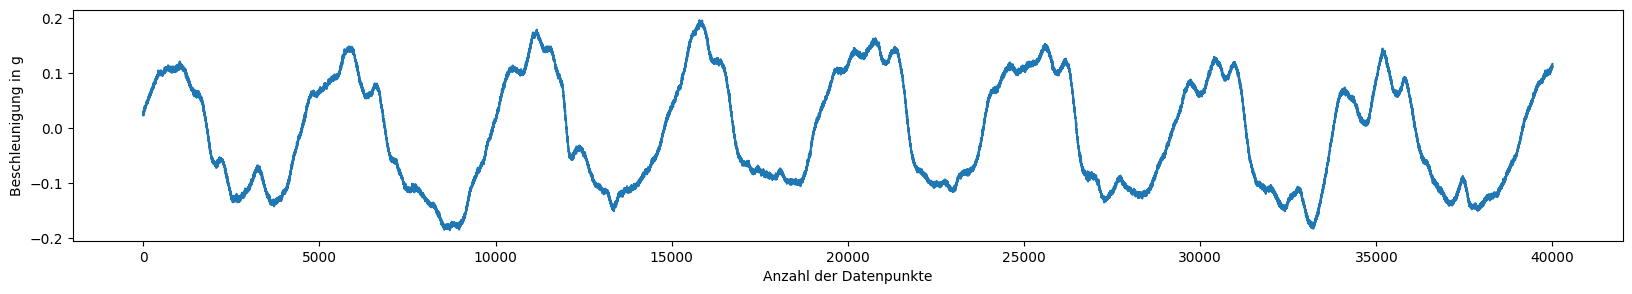

In [55]:
plotRandomDatapointsOfEachLabel(data_without_weights_filtered, labels_without_weights,type="line", axis="x")

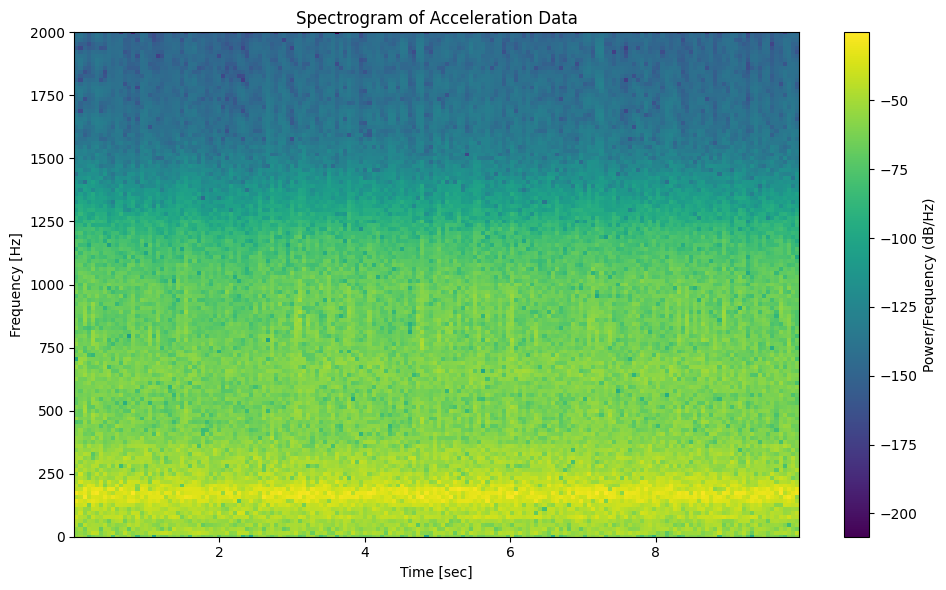

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def plot_spectrogram(acceleration_data, sample_rate=4000):
    # Compute the spectrogram
    f, t, Sxx = spectrogram(acceleration_data.flatten(), fs=sample_rate)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto', cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram of Acceleration Data')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.ylim(0, sample_rate / 2)  # Limit the y-axis to the Nyquist frequency
    plt.tight_layout()
    plt.show()




label ['largeloadcarriertrolley']


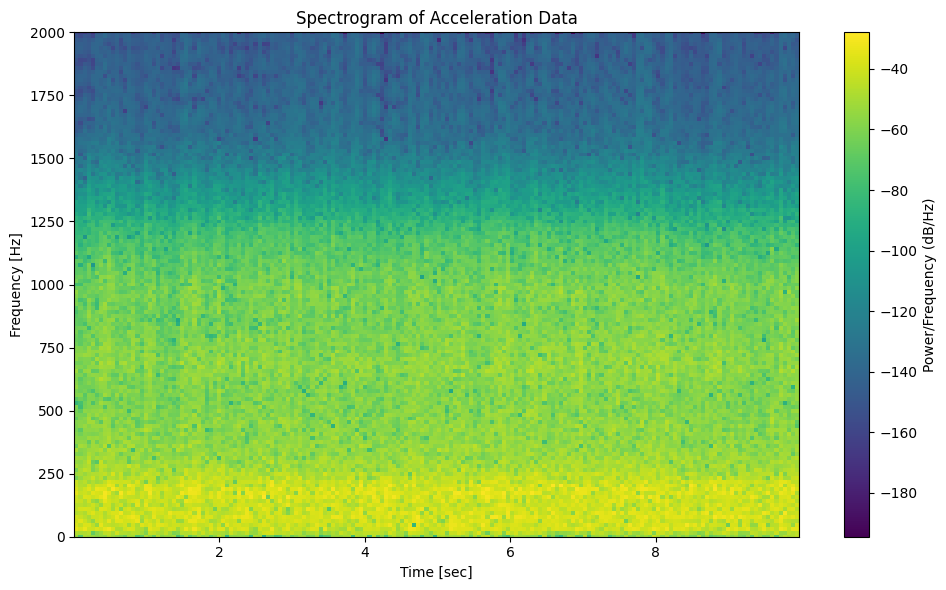

In [61]:
# Replace this with your actual acceleration data numpy array
index = 17
print("label", labels_without_weights[index])
acceleration_data = data_without_weights_filtered[index][:,0]

# Call the method to visualize the spectrogram
plot_spectrogram(acceleration_data)

In [62]:
import numpy as np
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean, cityblock, cosine

def compare_acceleration_data(data1, data2):
    metrics = {}
    
    # Calculate Pearson correlation coefficient for each axis
    pearson_correlations = [pearsonr(data1[:, i], data2[:, i])[0] for i in range(3)]
    metrics['pearson_correlations'] = pearson_correlations
    
    # Calculate Euclidean distance between the two datasets
    euclidean_distances = [euclidean(data1[:, i], data2[:, i]) for i in range(3)]
    metrics['euclidean_distances'] = euclidean_distances
    
    # Calculate Manhattan (city block) distance between the two datasets
    cityblock_distances = [cityblock(data1[:, i], data2[:, i]) for i in range(3)]
    metrics['cityblock_distances'] = cityblock_distances
    
    # Calculate Cosine similarity between the two datasets
    cosine_similarities = [1 - cosine(data1[:, i], data2[:, i]) for i in range(3)]
    metrics['cosine_similarities'] = cosine_similarities
    
    return metrics

# Replace these with your actual acceleration data numpy arrays
acceleration_data1 = np.random.rand(40000, 3)
acceleration_data2 = np.random.rand(40000, 3)

# Call the method to compare the acceleration data
comparison_metrics = compare_acceleration_data(acceleration_data1, acceleration_data2)

# Print the comparison metrics
print("Pearson Correlations:", comparison_metrics['pearson_correlations'])
print("Euclidean Distances:", comparison_metrics['euclidean_distances'])
print("Cityblock Distances:", comparison_metrics['cityblock_distances'])
print("Cosine Similarities:", comparison_metrics['cosine_similarities'])


Pearson Correlations: [-0.0017421663010600739, -0.0037119745729923556, -0.0034983696467771946]
Euclidean Distances: [81.5820980024716, 81.74967669456667, 81.75303187449073]
Cityblock Distances: [13301.422694778987, 13358.306238498146, 13328.02881681587]
Cosine Similarities: [0.7503637434188183, 0.7489511933365678, 0.7483843933477029]


In [73]:
print(labels_without_weights[0])
print(labels_with_weights[10])

['movingtable']
['movingtable']


In [74]:
# Call the method to compare the acceleration data
comparison_metrics = compare_acceleration_data(data_without_weights[0], data_with_weights[10])

# Print the comparison metrics
print("Pearson Correlations:", comparison_metrics['pearson_correlations'])
print("Euclidean Distances:", comparison_metrics['euclidean_distances'])
print("Cityblock Distances:", comparison_metrics['cityblock_distances'])
print("Cosine Similarities:", comparison_metrics['cosine_similarities'])

Pearson Correlations: [0.008429551977210901, -0.0014274322543837033, 0.0024782070297498055]
Euclidean Distances: [42.00135035203238, 54.416610473082706, 79.96452795248594]
Cityblock Distances: [6788.117738341982, 8381.077496963313, 12768.891238223354]
Cosine Similarities: [0.0414722415400508, 0.008311267724020577, 0.9122249536419617]


Results

Comparison of Line data (random sample size 1)

| class | 5kg | 0 kg |
| ---   | --- | --- |
|idle|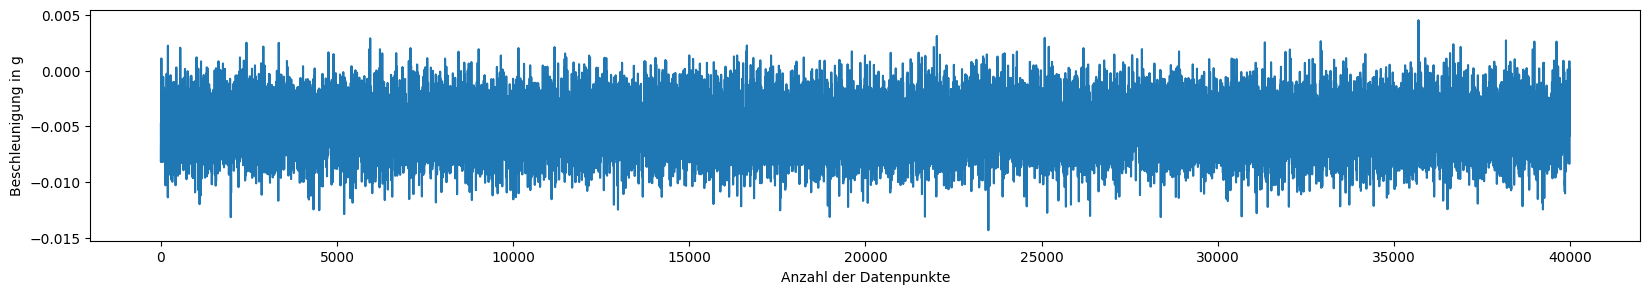 | 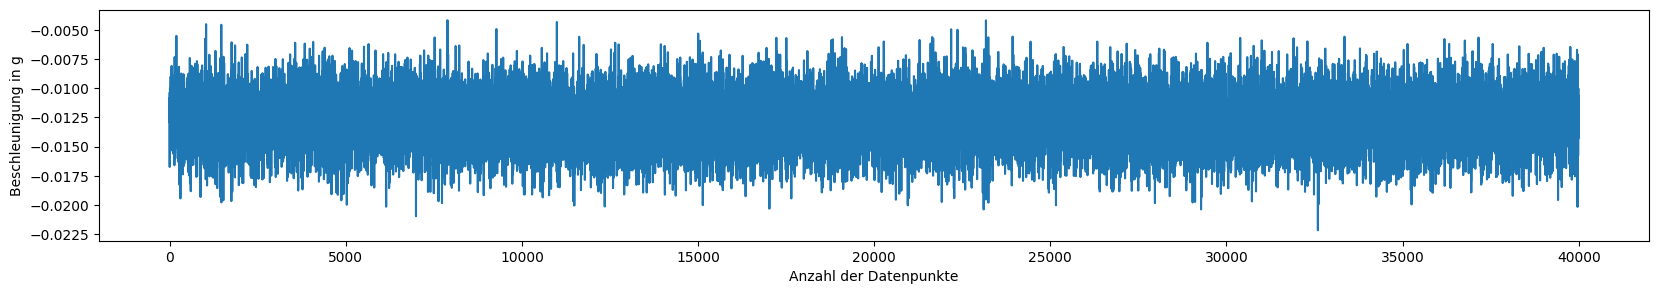 |
|largeloadcarriertrolley | 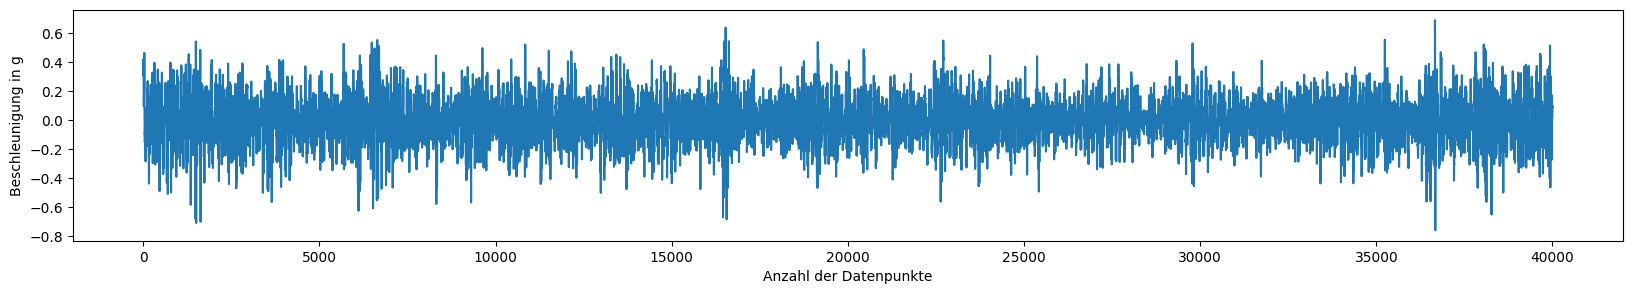 | 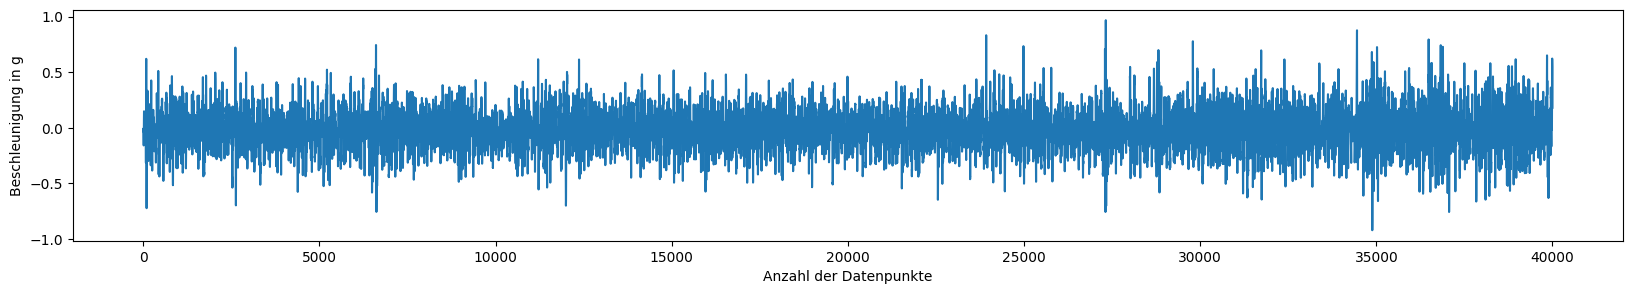|
|liftingandlowering | 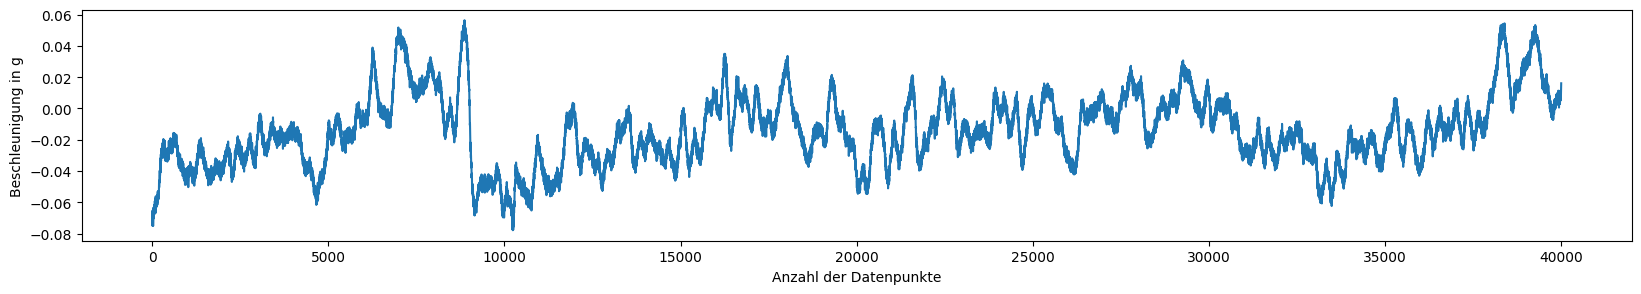 |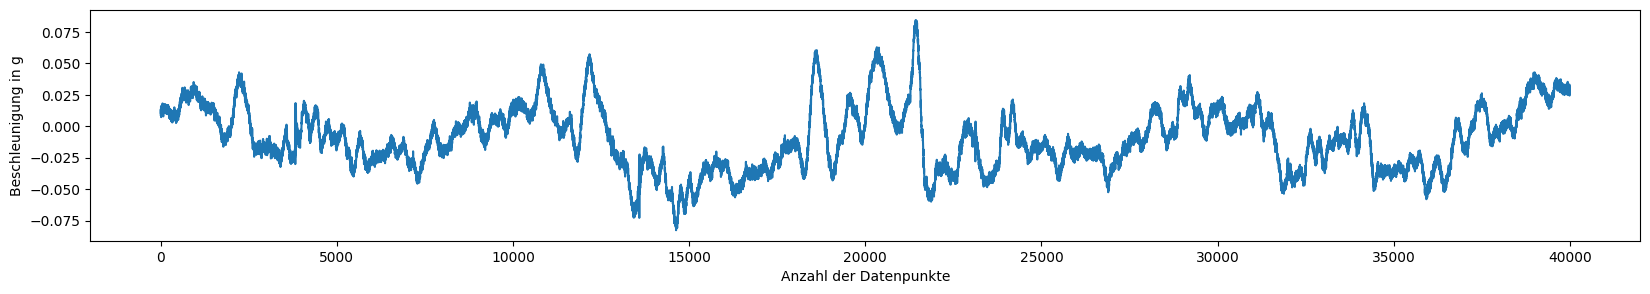 |
| movingtable | 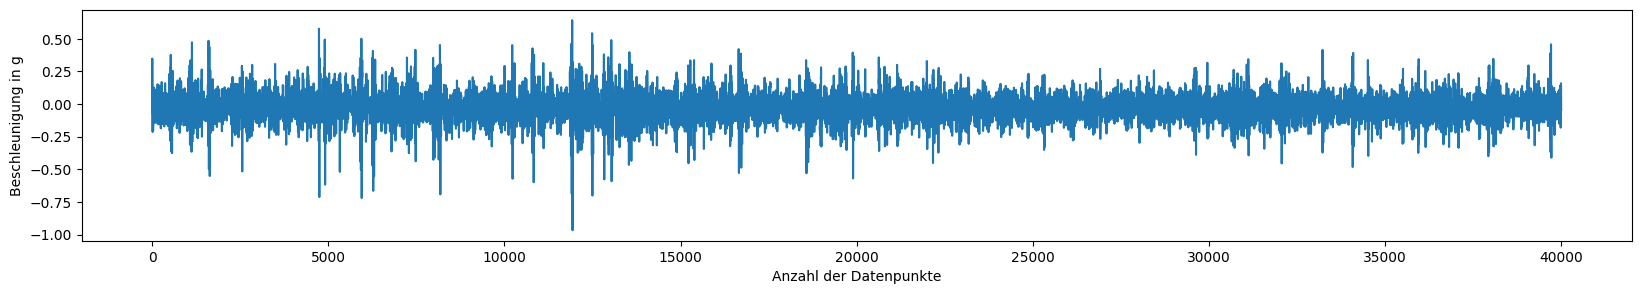| 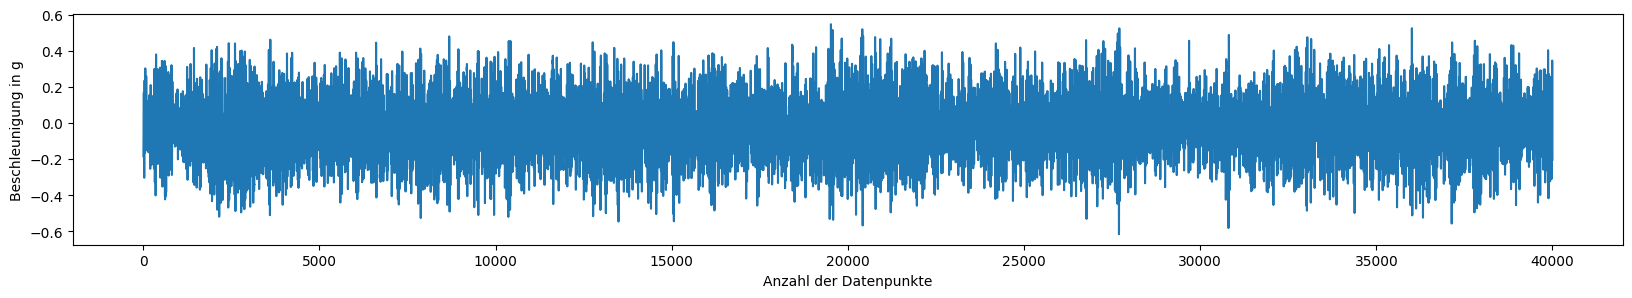|
| palletjack | 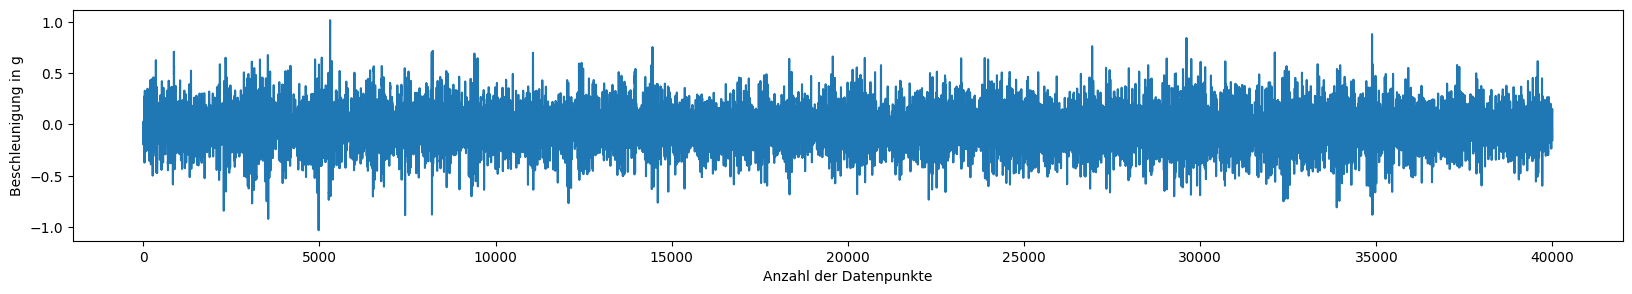 |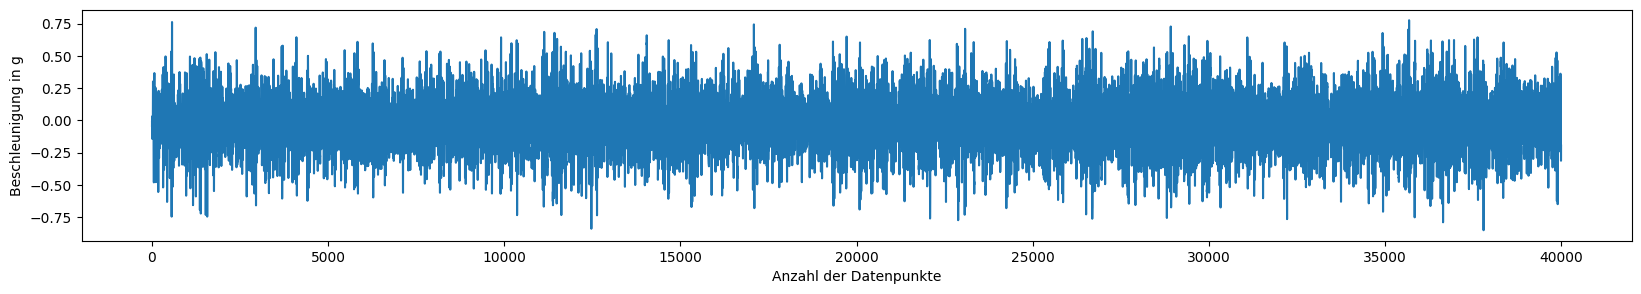 |
| rollerconveyor | 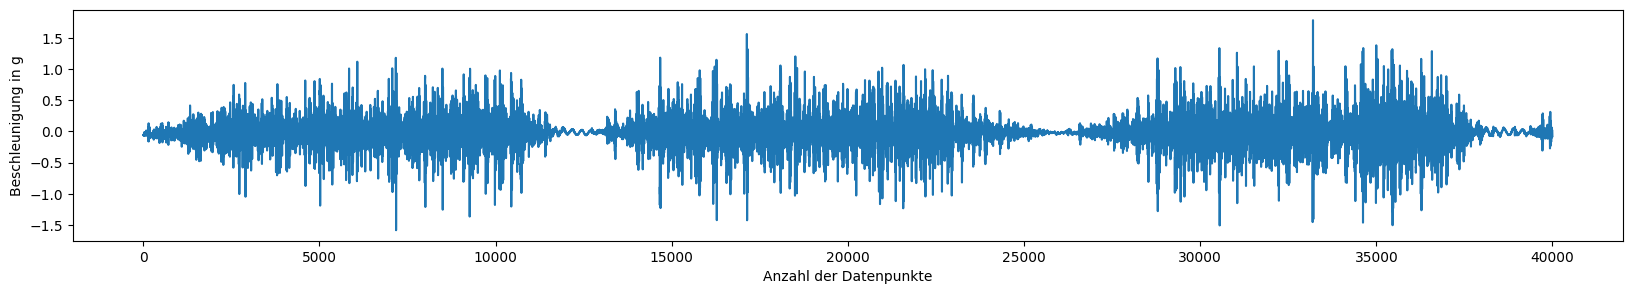 | 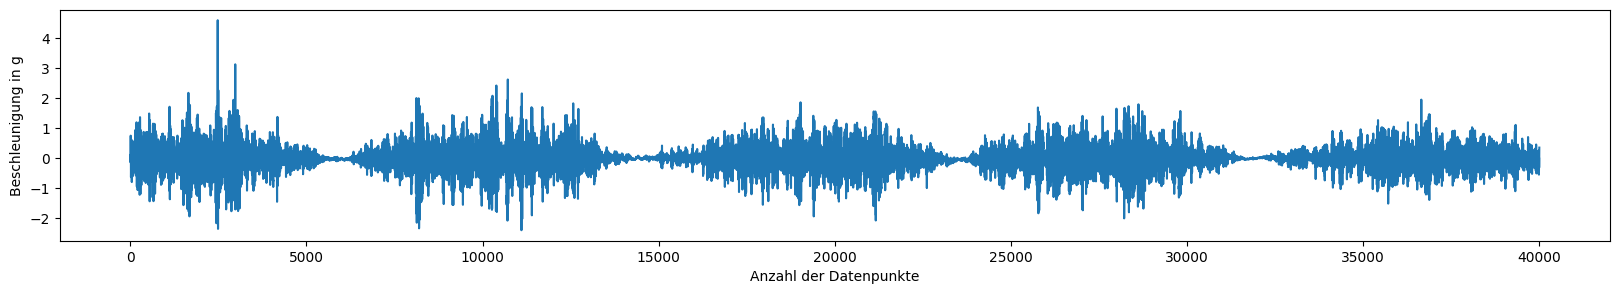|
| rotatehorizontally | 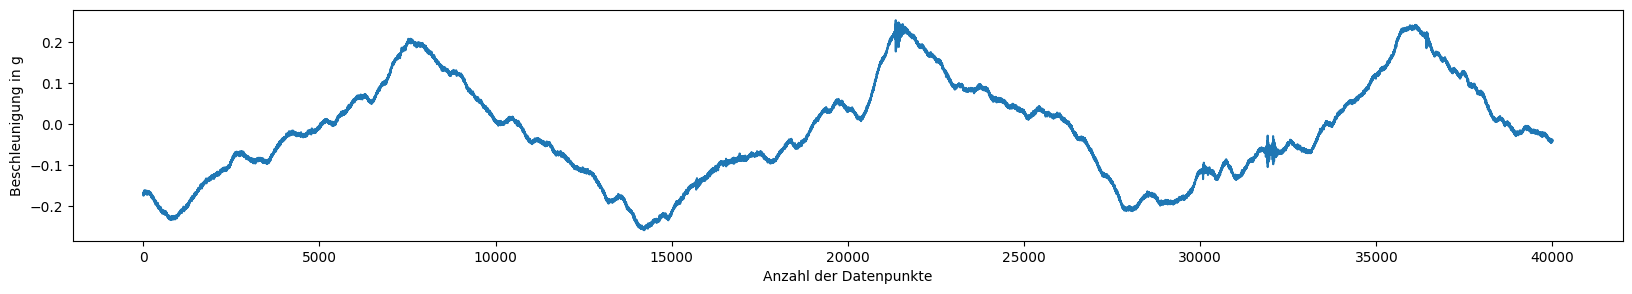 | 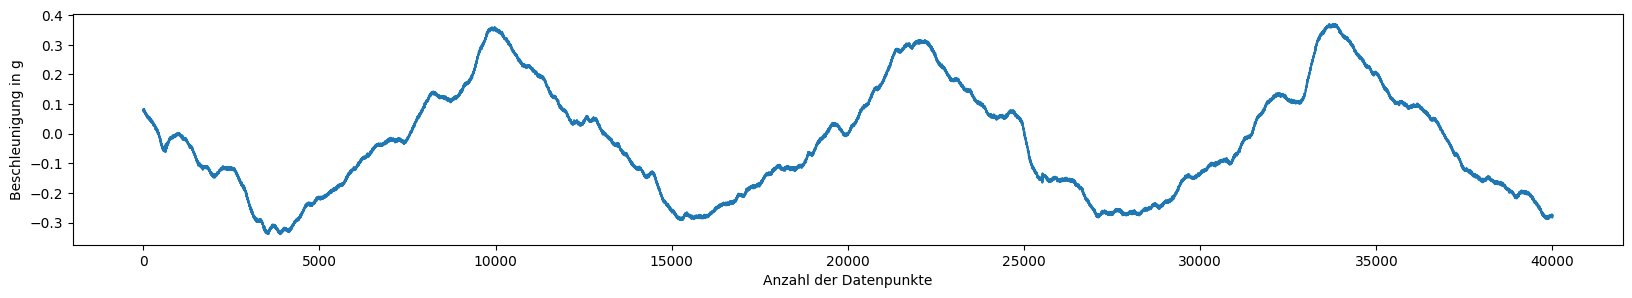|
| sacktrolley | 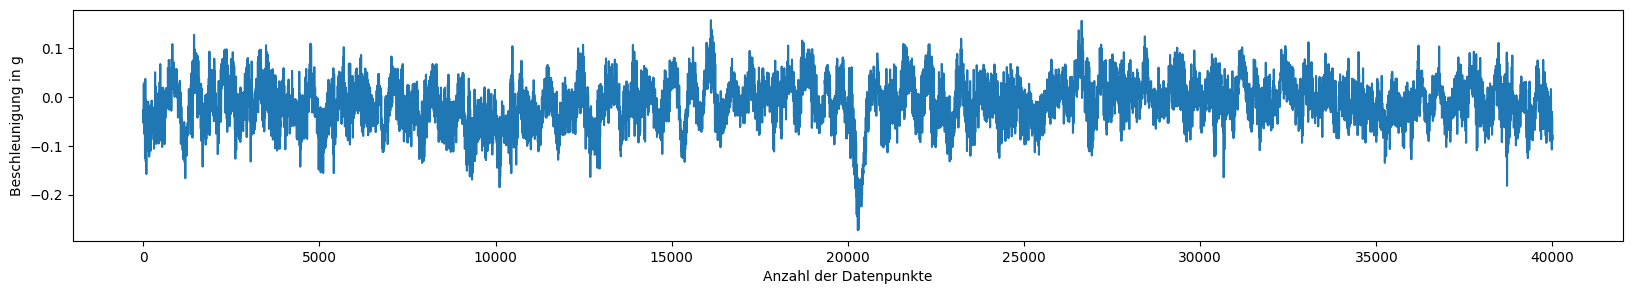 |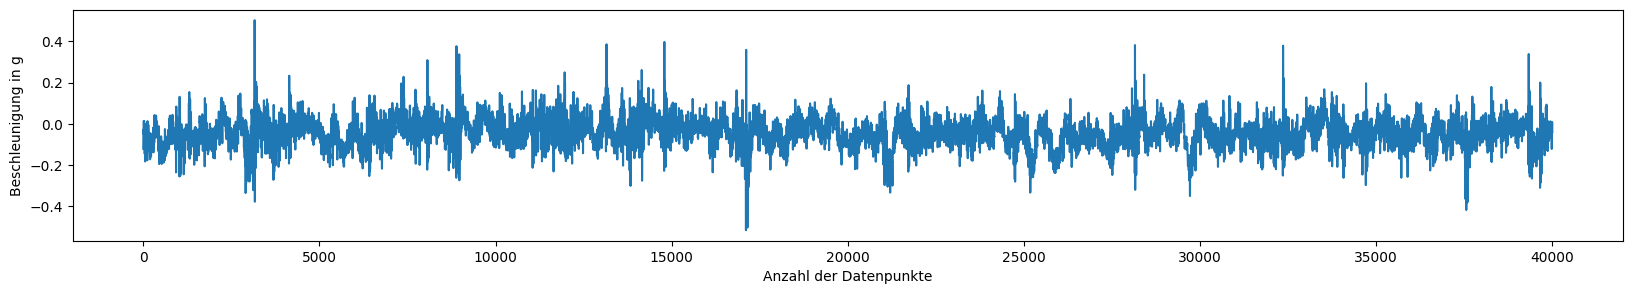 |
| walking | 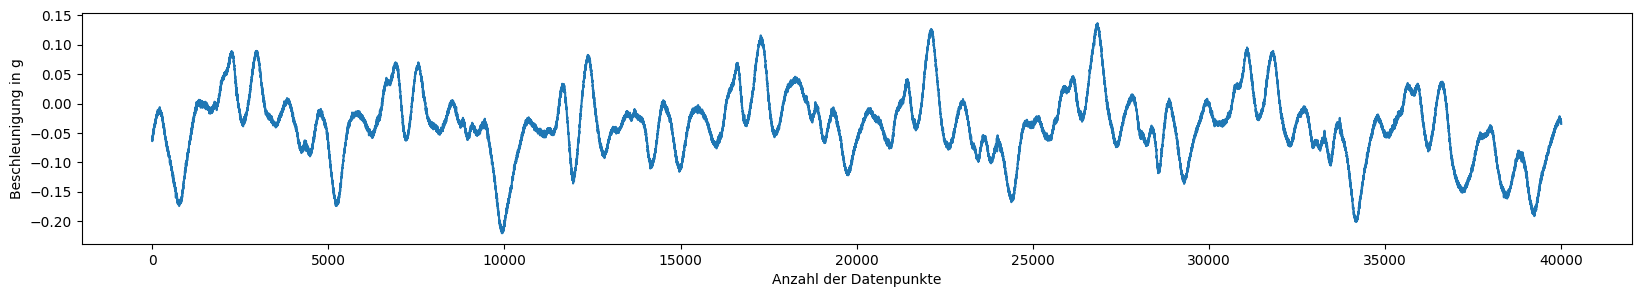 |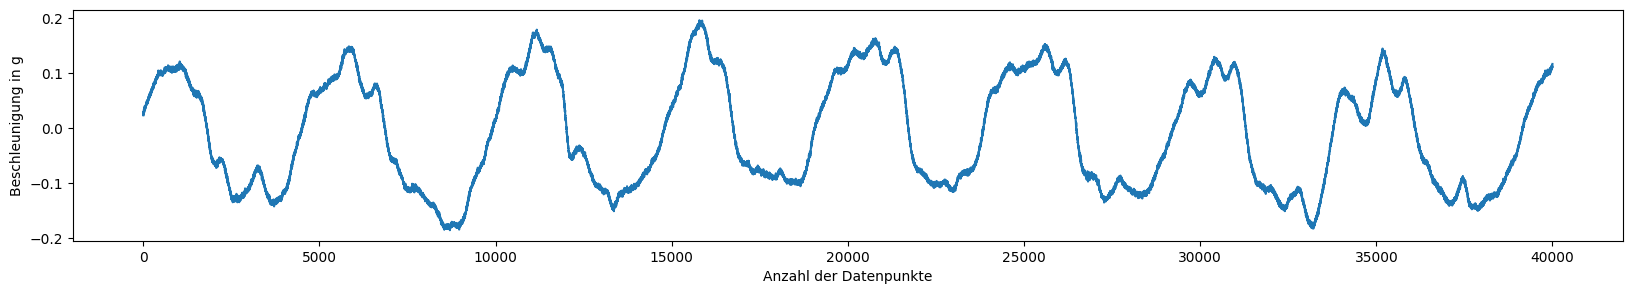 |

**Erkenntnis:**
1. LinienDiagramme sind nicht so gut für den direkten Vergleich gedacht
2. Ich sollte die Generierung von Vergleichs-Diagrammen automatisieren da 18x Cut+Paste nicht so viel Spaß macht -.-